# Data Wrangling with MongoDB

--------


## Open Street Map

### Introduction

The objective of this project is to wrangle and analyse  freely available map data from Open Street Map. 
The following s steps were followed:

* Selecting an area of interest and then download the map data as XML.
* Get basic understanding about the data.
* Audit data items and remove/clean data elements.
* Follwing cleaning of the data set, it is converted into an array of dictionaries according to the data model provided  
    earlier during the course. 
* The data model was built to load the data items into MongoDB.
* Once data items are correctly converted them turned into a JSON document 
   that will be imported into a mongodb collection.
* Once JSON documents are loaded into MongoDB gather basic statistics about the collection.
* A series of analysis on the data is done using Python driver for MongoDB.
* Description of the challenges faced in this project.
* Any other ideas about the dataset.

## Select an Area


The map chosen to conduct the data wrangling project isa Mapzen custom extract of  Kolkata city.The reason I chose this map is that it is the closest Metropolitan map area featured on Mapzen from my hometown and I completed my my college education in Kolkata. The extract includes the major landmarks of Kolkata and has parts of the twin city Howrah included within its boundaries.

* Map Area : Kolkata, India
* Map Source: Mapzen Metro extracts
* URL : https://s3.amazonaws.com/mapzen.odes/ex_gqfSCrJN1CMN63tZkc43S85rSkHML.osm.bz2 


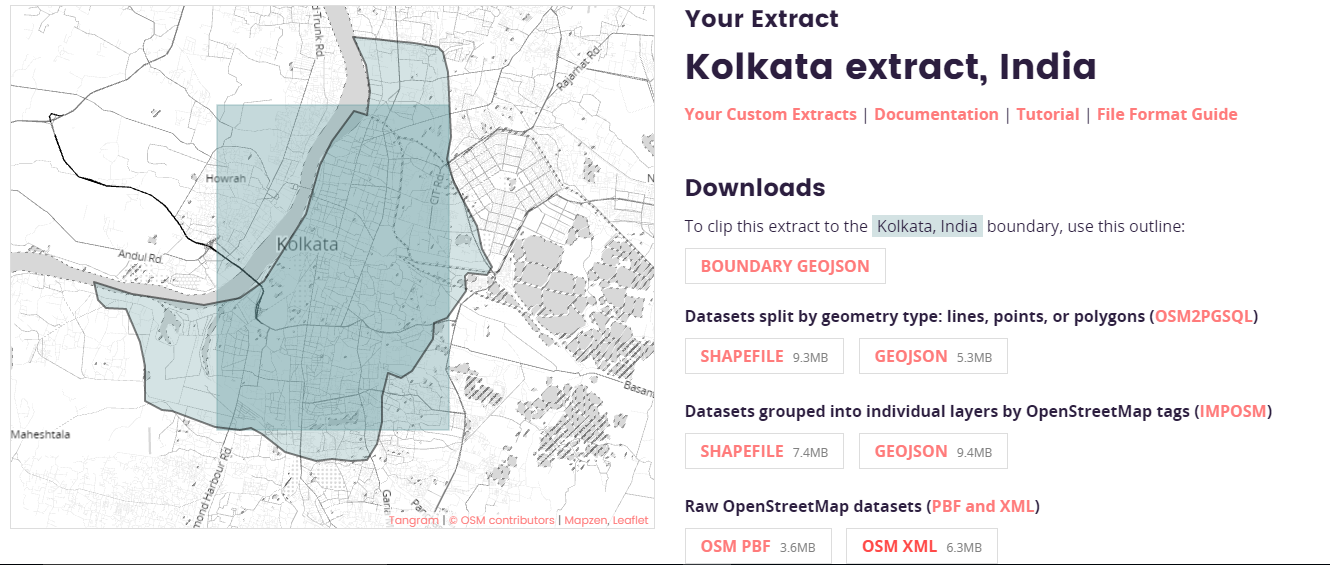

In [1]:
# Display map area
from IPython.display import Image
Image("Data Wrangling_HB_Kolkata_Extract.png")

## Download map data as XML

### Import Libraries

In [3]:
import xml.etree.cElementTree as ET
from lxml import etree as le
from collections import defaultdict, OrderedDict
import pprint
from datetime import datetime
import codecs
import json
from bson import json_util
import requests
import sys
import os
import subprocess
import time
import re

import pymongo
from pymongo import MongoClient

In [4]:
INPUT_FILENAME = 'Data Wrangling_HB_Kolkata_Extract.osm'
OUTPUT_DIR = 'Output_Data'
CURR_DIR = os.getcwd()+'\\'

if OUTPUT_DIR not in os.listdir(CURR_DIR):
    os.makedirs(CURR_DIR + OUTPUT_DIR)

## Get basic understanding about the data



In [5]:
# To find out what are the different types of tags present in our data set and also how many.

def count_tags(filename): 
   
    'Count no of different tags present in the given dataset'
    
    dict_tags = {}
    for event,element in ET.iterparse(filename):
        tag = element.tag
        if tag in dict_tags:
            dict_tags[tag] += 1
        else:
            dict_tags[tag] = 1
            
    return dict_tags

tags = count_tags(INPUT_FILENAME)
print(tags)

{'bounds': 1, 'tag': 117068, 'node': 506271, 'nd': 621389, 'way': 107851, 'member': 2342, 'relation': 721, 'osm': 1}


In [6]:
# To find out how many different users contributed to this openstreetmap dataset.

def count_users(filename):
    
    '''This function is written to count the number of distinct 
    users who contributed to the Ahemdabad Openstreetmap data'''
    
    users_set = set()
    for event,element in ET.iterparse(filename):
        tag = element.tag
        if tag == 'node' or tag == 'relation' or tag == 'way':
             users_set.add(element.attrib['user'])
        element.clear()        
    return users_set

users = count_users(INPUT_FILENAME)
print('Number of users contributed: ',len(users))

Number of users contributed:  285


## Data Auditing

Before we procees the data and add it into our database, we should check "k" value for each tag and see if there are any potential problems

In [7]:
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>();\'"?%#$@\,\. \t\r\n]')

problem_chars_set = set()
others_set = set()

def key_type(element, keys):
    '''This function is defined to categorize different "k" values'''
    if element.tag == "tag":
        tag_k_value = element.attrib['k']
        match_lower = re.search(lower,tag_k_value)
        match_lower_colon = re.search(lower_colon,tag_k_value)
        match_problemchars  = re.search(problemchars,tag_k_value)
        
        if match_lower :
            keys['lower'] += 1     
        elif match_lower_colon :
            keys['lower_colon'] += 1            
        elif match_problemchars:
            keys['problemchars'] += 1
            problem_chars_set.add(tag_k_value)
        else :
            keys['other'] += 1
            others_set.add(tag_k_value)
            
    return keys

def process_tags(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for event,element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys

process_tags(INPUT_FILENAME)

{'lower': 116044, 'lower_colon': 1003, 'other': 21, 'problemchars': 0}

Thus there are 21 other category tags and 0 problem char tags. The other category tags need to be identified so that those tags which might be useful for database insertion may be used.

In [8]:
print(others_set)

{'building_1', 'phone_1', 'GNS:id', 'AND_a_nosr_r', 'phone_2', 'IR:zone', 'AND:importance_level', 'name_1', 'phone_3', 'AND_a_w', 'ISO3166-2', 'is_in:iso_3166_2', 'IRrouterank', 'foot_1'}


All these tags may be discarded as they do nt offer much value. Now lets find out what all different "k" values are present in the data set.

In [9]:
def process_tags_k_val(filename):
    '''This function is written to find out 
    different k values present in dataset'''
    tags_k_values_dict = {}
    final_list = list(others_set) + list(problem_chars_set)
    for event,element in ET.iterparse(filename):
        if element.tag == 'tag' :
            tag_k = element.attrib['k']
            if tag_k not in final_list:
                if tag_k not in tags_k_values_dict:
                    tags_k_values_dict[tag_k] = 1
                else :
                    tags_k_values_dict[tag_k] += 1
                
    return tags_k_values_dict

tags = process_tags_k_val(INPUT_FILENAME)
print("Length of k values dictionary: ",len(tags))

Length of k values dictionary:  214


In [10]:
# Outputing file to external file tags.txt

def output_data(lst,func=None,filename=None):
    '''This function is written to write output 
    data to a file or show it on console'''
    if filename != None:
        filename = os.path.join(CURR_DIR+OUTPUT_DIR,filename)
        
        with open(filename,'w',encoding="utf-8") as f:
            if func != None:
                for val in lst:
                    f.write("{0} ----> {1}\n".format(val,func(val)))
            else:
                if type(lst) == type({}):
                    for val in sorted(lst.keys()):
                        f.write("{0} ----> {1}\n".format(val,lst[val]))
                else:   
                    for val in lst:
                        f.write("{0}\n".format(val))
    else : 
        if func != None:
            for val in lst:
                print("{0} ----> {1}".format(val,func(val)))
        else :
            for val in lst:
                print("{0}".format(val))    
output_data(tags,filename="tags.txt")

print ('tags.txt')

tags.txt


### Postal Codes auditing

Let us now take a look at different postal codes present in the dataset to validate them against correct format of Ahemdabad postal codes.This [website] lists out all the available postal codes of [Kolkata](http://www.mapsofindia.com/pincode/india/west-bengal/kolkata/), whcih are of the format (70****) and are 6 digits in length.
Now postal codes are defined under "addr:postcode","postal_code".



In [11]:
correct_postal_code_set = set()
incorrect_postal_code_set = set()

def validate_postal_code(code):
    '''This function is written to validate 
    postal code aganist regular expression'''
    validate_postal_code = re.compile(r'^70(\d{4})$') #regular expression to validate postal codes.
    match = re.search(validate_postal_code,code)
    return match
    
def process_postal_codes(filename):
    for event,element in ET.iterparse(filename):
        if element.tag == 'tag':
            tag_k = element.attrib['k']
            if tag_k in ['addr:postcode','postal_code']:
                tag_v = element.attrib['v'].replace(' ','')
                
                match = validate_postal_code(tag_v)
                if match :
                    correct_postal_code_set.add(tag_v)
                else:
                    incorrect_postal_code_set.add(tag_v)
                                        
process_postal_codes(INPUT_FILENAME)  

In [12]:
print(sorted(correct_postal_code_set))

['700001', '700004', '700006', '700009', '700010', '700012', '700013', '700014', '700015', '700016', '700017', '700019', '700020', '700021', '700023', '700025', '700026', '700027', '700029', '700031', '700037', '700038', '700039', '700046', '700053', '700054', '700067', '700071', '700073', '700078', '700087', '700107']


In [13]:
incorrect_postal_code_set

{'7000026', '70014', '711101', '711102'}

Hence most of the postal codes ake OK except for four instances. Of which, 711101 and 711102 are postal codes for Howrah, which is also included within the extract boundaries.The other two appear to be typing errors. Hence, they are not included in the database as they are incorrect and don't have the correct format.


## Problems Encountered in City Names

Next up is a look into the  values present in "addr:city" tag, to check whether the city name has been properly in every city tag.

In [14]:
def process_tags(filename,par_tag):
    '''This function is written to process tags with specific "k" value.'''
    tag_data_set = set()
    for event,element in ET.iterparse(filename):
        if element.tag == "tag":
            tag_k = element.attrib['k']
            if tag_k == par_tag:
                tag_data_set.add(element.attrib['v'])
    return tag_data_set

def process_tags_dict(filename,par_tag):
    '''This function is written to process tags with specific "k" value.'''
    tag_data_set = {}
    for event,element in ET.iterparse(filename):
        if element.tag == "tag":
            tag_k = element.attrib['k']
            tag_v = element.attrib['v']
            if tag_k == par_tag:
                if tag_v not in tag_data_set:
                    tag_data_set[tag_v] = 1
                else :
                    tag_data_set[tag_v] += 1
    return tag_data_set
                    
city_names = sorted(process_tags(INPUT_FILENAME,"addr:city"))
print(city_names)

['Howrah', 'KOLKATA', 'Kolkata', 'Kolkata, West Bengal', 'Kolkatta', 'kolkata']


The observations that can be drawn from the above listed city name are:

* "Kolkata" has various forms like ['KOLKATA', 'Kolkata', 'Kolkata, West Bengal', 'Kolkatta', 'kolkata'].
* As Kolkata is situated near by Howrah, some of the city tags has city value as ['Howrah'].
* Now lets write a function that would writen correct value of city.

In [15]:
def rectify_city_name(city_name):
    '''This function is written to rectify a given city name'''
    
    validate_city_kolkata = re.compile(r'Kolkat(a|a\,)',re.IGNORECASE)
    validate_city_howrah = re.compile(r'Howra(h|h\,)',re.IGNORECASE)
    
    result = None
    
    if re.search(validate_city_kolkata,city_name):
        result = "Kolkata"
        
    elif re.search(validate_city_howrah,city_name):
        result = "Howrah"
        
    else :
        result = "Kolkata"
    return result

output_data(city_names,func=rectify_city_name)

Howrah ----> Howrah
KOLKATA ----> Kolkata
Kolkata ----> Kolkata
Kolkata, West Bengal ----> Kolkata
Kolkatta ----> Kolkata
kolkata ----> Kolkata


## Auditing Phone Numbers

Let us check values present in "phone" tag to see if they are correct format or not

In [16]:
phone_numbers = process_tags(INPUT_FILENAME,"phone")
print(phone_numbers)

{'+91 9432315435', '+919051056376', '+91 33 2476 6161;+91 33 2474 8566', '03322844770', '+91 33 2229 9401', '033 2227 2625', '+91-033-22837161', '+913322522456', '+91 033 24660363', '09904567845', '+(91)-33-22224206', '033-2555-7656 / 7675', '03322695242', '9831116688', '033 4030 9999', '+913340696136', '+91 33 2236 9277', '089-6185-6857', '+913323291006', '+91 033 2486 8572', '+91906285598', '+913322529907', '+91-33-23298722', '+91 33 2212 0086', '+913322177397', '22821432', '+91 9836465400'}


 A lot of variation was observed from the standard phone number code format which is +91 xx xxxx xxxx. Some have incorrect length while others start with 0. Some dont have +91 prefixed or have +(91) 
 
 Hence, they need to be rectified

In [17]:
def rectify_phone_number(phone_number):
    '''This function is written to rectify a given phone number'''
    detect_multiple = re.compile(r'[/;]')
    match = re.search(detect_multiple,phone_number)
    num_lst = []
    rectified_lst = []
    if len(phone_number) < 10:
        return "Invalid Phone Number"
    else:
        if match:
            num_lst = convert_to_lst(phone_number,match.group())
        else:   
            num_lst = [phone_number]
        
        rectified_lst = validate_and_remove_problem_chars(num_lst)
        
        if len(rectified_lst) == 1:
            return rectified_lst[0]
        else:
            return rectified_lst
        
def convert_to_lst(phone_number,split_val):
    '''This function is written to handle 
    multiple phone numbers scenario'''
    num_lst = phone_number.split(split_val)
    nw_lst = []
    nw_lst.append(num_lst[0])
    for i in range(1,len(num_lst)):
        if len(num_lst[i]) < 10:
            new_num = num_lst[0][:len(num_lst[0])-len(num_lst[i])] + num_lst[i]
            nw_lst.append(new_num)
        else:
            nw_lst.append(num_lst[i])
    
    return nw_lst

def validate_and_remove_problem_chars(num_lst):
    '''This function is written to validate a 
    given phone number aganist standard format'''
    correct_format = re.compile(r'^(\+91) \d{2} \d{4} \d{4}')
    new_lst = []
    for number in num_lst:
        match = re.search(correct_format,number)
        if match :
            new_lst.append(number)
        else : 
            new_number = change_to_standard_format(number)
            new_lst.append(new_number)
    
    return new_lst 

def change_to_standard_format(phone_number):
    '''This function is written to convert a given phone number to standard format'''
    new_number = phone_number.replace('(','').replace(')','').replace('-','').replace(' ','')
    if new_number.startswith('+91'):
        new_number = '+91 ' + new_number[3:5] + ' ' + new_number[5:9] + ' ' +new_number[9:14]
    elif new_number.startswith('91'):
        new_number = '+91 ' + new_number[2:4] + ' ' + new_number[4:8] + ' ' +new_number[8:13]
    elif new_number.startswith('0'):
        new_number = '+91 ' + new_number[1:3] + ' ' + new_number[3:7] + ' ' +new_number[7:12]
    else:
        new_number = '+91 ' + new_number[:2] + ' ' + new_number[2:6] + ' ' +new_number[6:11]
    return new_number  

output_data(phone_numbers,rectify_phone_number,"correct_ph_numbers.txt") #output to external file


## Auditing Street Names


In [18]:
street_names = process_tags(INPUT_FILENAME,"addr:street")
output_data(street_names,filename="street_names.txt")    
print (street_names)

{'New Ballygunge Road', 'Dhakuria Station Lane', 'Lansdowne Road (Sarat Bose Road)', 'Rajdanga Gold Park', 'Shakespeare Sarani', 'B B Ganguly St, Calcutta Medical College, College Square, Kolkata,', 'Suburban Hospital Road', 'Rajdanga Main Road', 'New Road', 'Lee ROad (OC Ganguly Street)', 'Kalutola Lane', 'Bankim Chatterjee Street', 'Prafulla Sarkar Street', 'Hastings Park Road', 'Ballygunge Place', 'Lake Place', 'Purna Das Road', 'Ringo Starr Road', '73 & 75 Rash Behari Avenue', 'Mahim Halder Street', 'Banshi Dutta Road', "Queen's Way", 'Ananda Kumar Roychowdhury Lane', 'Shakespear Sarani', 'Ray Street', 'Russel Street', 'Free School Street (Mirza Ghalib Street)', 'Portland Park', 'Russell', '4, Gorky Terrace, kolkata- 700017', 'Raja Santosh Road', 'Gariahat Road', 'Karbala Tank Ln', 'Fairlie Place', 'Baje Shibpur Road', 'Rajdanga Purbapara RB Connector', 'Middleton Street', 'Dover Road', 'Sarat Ghosh Garden Road', 'Lenin Sarani', 'D. L. Khan Road', 'Eden Garden Road', 'Radhanath Cho

The observations that can be drawn from street data are :

* Most of the street names are either ending with word road, street, way, sarani, lane, connector which are in correct format.
* Few street names have their alternative names is parenthesis which may be left as it is as both the names are in vogue.
* Some are in incorrect format i.e, they are having address along with the street name, for eg."Gorky Terrace, kolkata- 700017".
* One of the Street names is mentioned in local language "Bengali" in addition to the English name like "ধর্মতলা লেন".

Now lets rectify street names.


In [19]:
def rectify_street_name(street_name):
    '''This function is written to rectify the given street name'''
    incorrect_names = {'Rameswar Shaw Rd':'Rameswar Shaw Road', 
                       'Shibpur Rd':'Shibpur Road',
                       'Gora Chand Rd':'Gora Chand Road',
                       'Ultadanga Main Rd':'Ultadanga Main Road',
                       'Dharmatala lane (ধর্মতলা লেন)':'Dharmatala Lane',
                       '4, Gorky Terrace, kolkata- 700017':'Gorky Terrace',
                       'Ward no 32, Near Mandirtala Bus Stop, Shibpur Rd, Shibpur, Howrah, West Bengal 711102': 'Shibpur Road',
                        'B B Ganguly St, Calcutta Medical College, College Square, Kolkata':'B.B. Ganguly Steet',
                       'Alipore, Kolkata':'Alipore Road',
                       'C.I.T. SCHEME VII(M)':'CIT Road',
                       'Karbala Tank Ln':'Karbala Tank Lane',
                       'A.J.C.BOSE road, 3RD FLOOR':'A.J.C.BOSE Road',
                       'Lee ROad (OC Ganguly Street)':'Lee Road (OC Ganguly Street)',
                       '32 Park Street':'Park Street',
                       '73 & 75 Rash Behari Avenue':'Rash Behari Avenue',
                       '901A, 9th Floor, Fort Knox, 6, Camac, St. Elgin, Elgin, Kolkata, West Bengal 700017':'Camac Street'}
    if street_name in incorrect_names:
        return incorrect_names[street_name]
    else:
        new_street_name = street_name.lower().strip(' ')        
        if new_street_name.endswith('kolkata'):
            new_street_name = new_street_name.replace('kolkata','').replace(',','')
        
        return new_street_name.title()





## Problems Encountered In Building Levels Data

In [20]:
building_levels = process_tags(INPUT_FILENAME,"building:levels")
print(building_levels)

{'6', '7', '1,2,3,4,5', '8', '5', '9', '2', '18', '2, 4, 6', '3', '10', '1', '0', '12', '4'}


The observations that can be drawn from the building levels data are:

Most of the building levels are single values.
Few values are lists which comprises of all the levels.
One or more value are inccorect like '1601'.
Lets write a function that would ignore incorrect values and return a correct set of building values.

In [21]:
def rectify_building_level_data(level):
    '''This function is written to rectify building levels data'''
    level_pattern = re.compile(r'[,]')
    match = re.search(level_pattern,level)
    
    if match:
        level_lst = level.split(match.group())
        return [int(level) for level in level_lst]
    elif len(level) <= 2:
        return [int(level)]
    else:
        return None    
    
output_data(building_levels,func=rectify_building_level_data)     

6 ----> [6]
7 ----> [7]
1,2,3,4,5 ----> [1, 2, 3, 4, 5]
8 ----> [8]
5 ----> [5]
9 ----> [9]
2 ----> [2]
18 ----> [18]
2, 4, 6 ----> [2, 4, 6]
3 ----> [3]
10 ----> [10]
1 ----> [1]
0 ----> [0]
12 ----> [12]
4 ----> [4]


Now lets write a function that will convert the xml dataset to json documents, which can be later be inserted to mongoDB.

In [22]:
CREATED = [ "version", "changeset", "timestamp", "user", "uid"]
EXPECTED = ["amenity","cuisine","name","phone","religion","atm",'building','building:levels','landuse',
            'highway','surface','lanes','bridge','maxspeed','leisure','sport','operator']

speed = re.compile(r'(\d)*')

def shape_element(element):
    '''This function is written to convert each xml tag to a json object'''
    
    node = {}
    if element.tag == "node" or element.tag == "way" :
        
        created_dict = {}
        attributes = element.attrib
        pos = []
        for k,v in attributes.items():
            if k in CREATED :
                created_dict[k] = v
            else:
                if k not in ["lat","lon"]:
                    node[k] = v
        node["type"] = element.tag
        
        if "lat" in attributes and "lon" in attributes:
            node["pos"] = [float(attributes["lat"]),float(attributes["lon"])]     
        node["created"] = created_dict 
        
        node_refs = []
        address = {}
        
        for elem in element.iter('nd'):
            node_refs.append(elem.attrib["ref"])
            
        for elem in element.iter('tag'):
            tag_k = elem.attrib['k']
            tag_v = elem.attrib['v']

            
            if tag_k == "postal_code":
                tag_k = "addr:postcode"
                                            
            if tag_k.startswith('addr:') and  tag_k.count(':') == 1:
                
                if tag_k == "addr:postcode" and tag_v not in correct_postal_code_set:
                    tag_v = None
                
                elif tag_k == "addr:city" :
                    tag_v = rectify_city_name(tag_v)
                 
                elif tag_k == "addr:street":
                    tag_v = rectify_street_name(tag_v)
                
                
                if tag_v != None:
                    address[tag_k.split(':')[1]] = tag_v
                
            elif tag_k in EXPECTED:
                
                if tag_k == "phone":
                    tag_v = rectify_phone_number(tag_v)
                    if tag_v == "Invalid Phone Number":
                        tag_v = None
                        
        
                
                elif tag_k=="building:levels":
                    tag_v = rectify_building_level_data(tag_v)
                    
                elif tag_k == "maxspeed" or tag_k == 'lanes':
                    match = re.search(speed,tag_v)
                    tag_v = int(match.group())
                
                if tag_v != None:            
                    node[tag_k] = tag_v
                                
        if len(node_refs) !=0 :
            node["node_refs"] = node_refs
            
        if len(address) != 0:
            node["address"] = address
    
        
        return node
    else:
        return None

In [23]:
def get_element(INPUT_FILENAME, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    # iterator/tree-builder object providing (event, elem) pairs 
    context = ET.iterparse(INPUT_FILENAME, events=('start', 'end'))

    # moves to next in iterator/tree-builder object (points to <osm element)
    _, root = next(context)
    
    # loop over event, elem pair in iterator/tree-builder object
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            # clears root after each iteration
            root.clear()

In [24]:
def process_map(file_in, pretty=False):
    file_out = "{0}.json".format(file_in)
    with codecs.open(file_out, "w") as fo:
        for element in get_element(file_in):
            el = shape_element(element)
            if el:
                if pretty:
                    fo.write(json.dumps(el, indent=2) + "\n")
                else:
                    fo.write(json.dumps(el) + "\n")

In [25]:
process_map(INPUT_FILENAME)

## Data Wrangling With DB and File Sizes

In [26]:
client = pymongo.MongoClient('localhost:27017')
db_name = 'openstreetmap'
collection_name = 'kolkatadata'
file_name = '"Data Wrangling_HB_Kolkata_Extract.osm.json"'

db = client['db_name']
kolkata_osm = db['collection_name']
    
if collection_name in db.collection_names():
    kolkata_osm.drop()

cmd = "mongoimport --db " + db_name +' --collection ' + collection_name + ' --file ' +   file_name
subprocess.call(cmd)

0

### File sizes

In [29]:

def getSize(filename):
    input_file_size_b = os.path.getsize(filename)
    input_file_siz_mb = (input_file_size_b)/(1024*1024)
    return round(input_file_siz_mb,2)

print("Size of the input file: {0} MB".format(getSize(INPUT_FILENAME)))
print("Size of the ouput Json file: {0} MB".format(getSize("Data Wrangling_HB_Kolkata_Extract.osm.json")))

Size of the input file: 109.38 MB
Size of the ouput Json file: 125.97 MB


### Print first document

In [31]:
from pymongo import MongoClient
from pprint import pprint
client = MongoClient('mongodb://localhost:27017/')

db = client.openstreetmap
kolkata_osm = db.kolkatadata

print ('\nFirst document:', kolkata_osm.find_one())


First document: {'_id': ObjectId('5986ed794ffd78edec25e597'), 'id': '245706884', 'type': 'node', 'pos': [22.5490661, 88.3210462], 'created': {'changeset': '32847838', 'timestamp': '2015-07-24T12:07:20Z', 'uid': '2891142', 'user': 'shashi2', 'version': '7'}}


### Number of records


In [33]:
total_records = kolkata_osm.find().count()
print('Total Number Of Records: ',total_records)

Total Number Of Records:  2261715


### Number of ways :

In [34]:
total_nodes = kolkata_osm.find({"type":"way"}).count()
print('Number of ways: ',total_nodes)

Number of ways:  323553


### Number of nodes

In [35]:
total_nodes = kolkata_osm.find({"type":"node"}).count()
print('Number of nodes: ',total_nodes)

Number of nodes:  1938162


### Number of unique users

In [36]:
distinct_users = len(kolkata_osm.distinct('created.user'))
print('Number of users contributed: ',distinct_users)

Number of users contributed:  280


### Top 5 users who contributed

In [38]:
top_five_users = kolkata_osm.aggregate([{"$group":{"_id":"$created.user",
                                   "count":{"$sum":1}}},
                        {"$sort":{"count":-1}},
                        {"$limit":5}])

for user in top_five_users:
    print("Total number of entries {0} made : {1}".format(user["_id"],user["count"]))

Total number of entries hareesh11 made : 247394
Total number of entries Rondon237 made : 215399
Total number of entries samuelmj made : 156729
Total number of entries vikramsingh made : 139243
Total number of entries thrinath made : 124069


## Further Data Exploration With MongoDB

### Top 5 Amenities

In [39]:
top_five_amenities = kolkata_osm.aggregate([{"$match":{"amenity":{"$exists":1}}},
                                             {"$group":{"_id":"$amenity",
                                                       "count":{"$sum":1}}},
                                             {"$sort":{"count":-1}},
                                             {"$limit":5}])

for amenity in top_five_amenities:
    print("Total number of {0}'s Present : {1}".format(amenity["_id"].title(),amenity["count"]))


Total number of Restaurant's Present : 166
Total number of School's Present : 166
Total number of Place_Of_Worship's Present : 121
Total number of Hospital's Present : 110
Total number of Bank's Present : 110


### Number Of Atm's Present

Some of the banks have atms too, so to count the total number, we need to include both atm's and banks with atm's.

In [40]:
total_atms = kolkata_osm.find({"$or":[{"amenity":"bank","atm":"yes"},{"amenity":"atm"}]}).count()
print("Total Number of Atms's :{0}".format(total_atms))

Total Number of Atms's :87


### Top 3 Cuisines

In [41]:
top_three_cuisines = kolkata_osm.aggregate([{"$unwind":"$cuisine"},
                                             {"$group":{"_id":"$cuisine",
                                                       "count":{"$sum":1}}},
                                            {"$sort":{"count":-1}},
                                            {"$limit":3}])

[cuisine["_id"].title() for cuisine in top_three_cuisines]    

['Indian', 'International', 'Chinese']

### Top 5 Building Types

In [44]:
top_five_building_types = kolkata_osm.aggregate([{"$match":{"building":{"$exists":1,"$ne":"yes"}}},
                                                   {"$group":{"_id":"$building",
                                                       "count":{"$sum":1}}},
                                                    {"$sort":{"count":-1}},
                                                    {"$limit":5}])
for building_type in top_five_building_types:
    print("{0}: {1}".format(building_type["_id"].title(),building_type["count"]))

House: 118
Apartments: 58
Residential: 57
Industrial: 36
School: 36


### Top 3 Tallest Buildings

In [45]:
top_levels = kolkata_osm.aggregate([{"$match":{"building:levels":{"$exists":1}}},{"$unwind":"$building:levels"},
                        {"$group":{"_id":"$name",
                                     "max_level":{"$max":"$building:levels"}}},
                        {"$sort":{"max_level":-1}},
                        {"$limit":3}])


for level in top_levels:
    print("{0}: {1}".format(level["_id"].title(),level["max_level"]))

Tata Centre: 18
Jindal House: 12
Ganga Jamuna Apartments: 10


### Top 3 Landuses

In [47]:
top_three_landuses = kolkata_osm.aggregate([{"$match":{"landuse":{"$exists":1}}},
                                               {"$group":{"_id":"$landuse","count":{"$sum":1}}},
                                               {"$sort":{"count":-1}},
                                               {"$limit":3}])

for landuse in top_three_landuses:
    print("{0}: {1}".format(landuse["_id"].title(),landuse["count"]))

Residential: 2355
Industrial: 642
Commercial: 123


### Leisure Types

In [48]:
print(kolkata_osm.distinct('leisure'))

['playground', 'park', 'stadium', 'pitch', 'recreation_ground', 'sports_centre', 'track', 'yes', 'garden', 'swimming_pool']


### Sport Types

In [ ]:
print(Data Wrangling_HB_Kolkata_Extract.osm.distinct('sport'))



## Way Tag Data Exploration

### Highway Types

In [49]:
highway_types = kolkata_osm.distinct('highway')
print(highway_types)

['bus_stop', 'crossing', 'motorway', 'secondary', 'unclassified', 'primary', 'tertiary', 'residential', 'trunk', 'motorway_link', 'service', 'footway', 'primary_link', 'tertiary_link', 'secondary_link', 'pedestrian', 'road', 'track', 'path', 'living_street', 'steps']


### Surface Types

In [50]:
surface_types = kolkata_osm.aggregate([{"$match":{"surface":{"$exists":1}}},
                        {"$group":{"_id":"$surface","count":{"$sum":1}}},
                         {"$sort":{"count":-1}}])

for type in surface_types:
    print("{0}: {1}".format(type["_id"].title(),type["count"]))

Asphalt: 96
Paved: 81
Grass: 6
Ground: 3
Dirt: 3


### Bridges

In [51]:
bridges = kolkata_osm.aggregate([{"$match":{"bridge":"yes"}},
                        {"$group":{"_id":"$name"}}])

print(sorted([bridge["_id"].title() for bridge in bridges if bridge["_id"] != None]))

['Acharya Jagadish Chandra  Bose Flyover', 'Acharya Jagadish Chandra Bose Flyover', 'Bamungachi Bridge', 'Bangal Babu Bridge', 'Bankim Setu', 'Belvedere Road', 'Bondel Road Flyover', 'Debendra Lal Khan Road', 'Dhakuria Bridge', 'Eastern Met. Bypass To Nazrul Islam Avenue (Vip Rd.) Flyover', 'Eastern Metropolitan Bypass', 'Garden Reach Road', 'Howrah Bridge', 'J.B.S. Haldane Avenue', 'Judges Court Road', 'Karl Marx Sarani', 'Kolkata Circular Railway', 'Majherhat Bridge', 'Nazrul Isalm Avenue (Vip Rd.) To Eastern Met. Bypass Flyover', 'P Majumdar Road', 'Parama Flyover', 'Park Street Flyover', 'Rabindra Setu', 'Radha Gobinda Kar Road', 'Rash Behari Avenue Connector', 'State Highway 1', 'Tala Bridge', 'Taratala Flyover', 'To Nazrul Islam Avenue (Vip Rd.)', 'Vidyasagar Setu', 'Vivekanada Road']


### Top 3 MaxSpeeds

In [52]:
max_speeds = kolkata_osm.aggregate([{"$match":{"maxspeed":{"$exists":1}}},
                                      {"$group":{"_id":"$name","speed":{"$max":"$maxspeed"}}},
                                      {"$sort":{"speed":-1}},
                                      {"$limit":3}])
for speed in max_speeds:
    print("{0}: {1} Mph".format(speed["_id"].title(),speed["speed"]))

Vidyasagar Setu: 50 Mph
Diamond Harbour Road: 40 Mph
Gariahat Road: 40 Mph


### Roads With Max Lanes

In [53]:
max_lanes = kolkata_osm.aggregate([{"$match":{"lanes":{"$exists":1}}},
                                      {"$group":{"_id":"$name","speed":{"$max":"$lanes"}}},
                                      {"$sort":{"speed":-1}},
                                      {"$limit":2}])
for lane in max_lanes:
    print("{0}: {1} Lanes".format(lane["_id"].title(),lane["speed"]))

Gariahat Road: 8 Lanes
Bankim Setu: 6 Lanes


## The Conclusion

Though OpenStreetMap data seems to be fairly sorted in terms of the data distribution(nodes, ways and relations),Its becomes problematic when it comes to data representation in terms of tags due to following reasons:

Different tags have been used to represent the same data like "postal_code" and "addr:postcode".
Phone numbers are in different formats.
Street names are having city and states names appended.
City names are having local area names appended.
To avoid these problems OpenStreetMap should provide various templates based on the country, so that data would be more clean and sorted.

### Improvements

The dataset can be improved as per below points.
* if street names can be updated to remove the junks
* if it is possible to add some more information regarding nodes


### Benefits

* **Benefit #1**
It will help create a standard set of names for the streets, which will immensely help in creating proper address fields that can be used in a variety of fields like targeted delivery of products, point to point navigationational aids and even improve efficiency of self driving cars.


* **Benefit #2**
Greater information added in a ordered manner helps in classification of data properly as well as retrieval of data easier, thus smoothening out the entire operationn.



### Anticipated Issues


* **Issue #1**
Training and awareness amongst the humans working/entering data is an issue which leads to misclassification of data. Hence, updating of HR is vital.

* **Issue #2**
Use of regional languages/idioms/references while entering data which may result in non-local people experiencing difficulty to access data.


### References used

* http://wiki.openstreetmap.org/wiki/Main_Page
* https://docs.mongodb.com/ecosystem/drivers/
* http://stackoverflow.com